# Задание 1. RNN, LSTM и GRU

In [ ]:
# попробовать предсказать одномерный временной ряд не забыть посчитать вывести метрики мсе

Используя код из лекции, попробуйте обучить RNN с размерностью скрытого состояния `hidden_size=2` на следующих периодичных данных и визуализируйте результат.

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn

import random
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [ ]:
input_size = 1
hidden_size = 2

Функция для визуализации на базе материала из лекции:

In [ ]:
def display(data, pred=None, vert=None, title="Prediction"):
    data = np.array(data).reshape((len(data), 1))
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Some periodic function")
    if pred != None:
        plt.plot(pred, label=title)
    if vert != None:
        plt.axvline(x=vert, c="r", linestyle="--")
    plt.legend()
    plt.grid()
    plt.show()

Генерация данных для обучения:

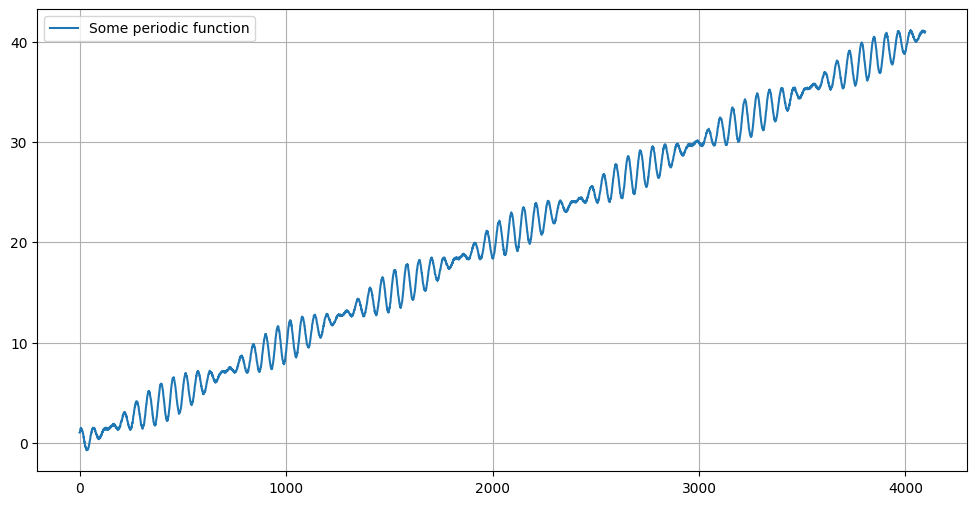

In [ ]:
training_data = []
for i in range(4096):
    training_data.append(
        math.sin(i / 10) + math.cos((i) / 9) + i / 100 + (random.random() - 0.5) / 5
    )

display(training_data)

**Подготовка данных**

Данные имеют ярко выраженный линейный тренд
"A time series with a trend is called non-stationary."
https://machinelearningmastery.com/time-series-trends-in-python/

Удалим его, используя функцию [detrend](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) из `scipy.signal`.

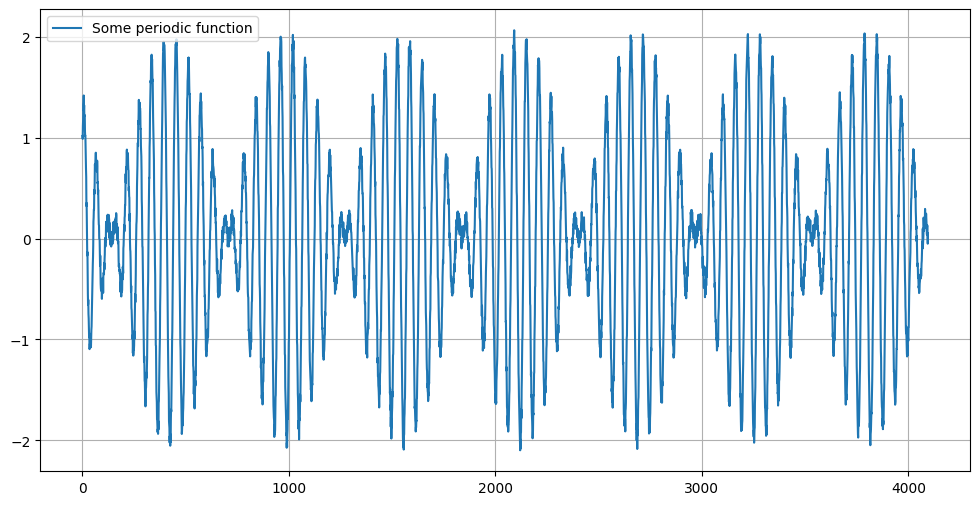

In [ ]:
from scipy.signal import detrend

stationary_data = detrend(training_data)
display(stationary_data)

Сохраним тренд, чтобы иметь возможность восстановить данные:

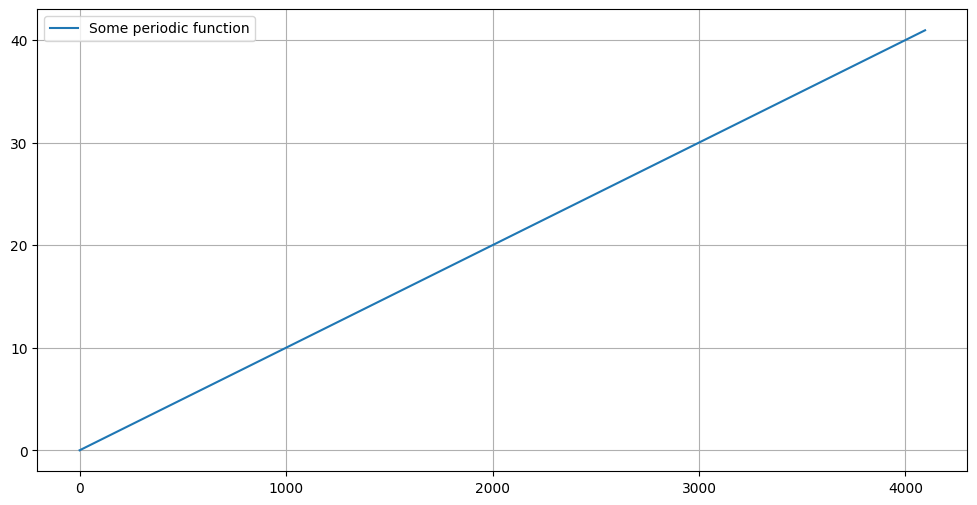

In [ ]:
trend = training_data - stationary_data
display(trend)

Теперь следовало бы стандартизовать данные. Но для наших данных среднее равно нулю, а дисперсия — почти единица, так что этот шаг можено опустить.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(stationary_data.reshape(-1, 1))
print(f"Var: {scaler.var_[0]:.2f} Mean {scaler.mean_[0]:.2f}")

Var: 0.98 Mean 0.00


In [ ]:
stationary_data

array([ 1.01610472,  0.98689265,  1.11731307, ...,  0.01206227,
       -0.0510365 ,  0.05103296])

In [ ]:
stationary_data.shape

(4096,)

In [ ]:
len(training_data)

4096

Обучите на этих данных модель с простым RNN слоем и визуализируйте результат.

In [ ]:
def time_series_train(model, num_epochs=2000, learning_rate=0.01):
    criterion = torch.nn.MSELoss()  # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        y_pred, h = model(x_train)  # we don't use h there, but we can!
        optimizer.zero_grad()

        # obtain the loss
        loss = criterion(y_pred[0], y_train)  # for shape compatibility
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

def time_series_plot(train_predict):
    data_predict = train_predict.data
    y_data_plot = y.data

    # Denormalize
    data_predict = data_predict.squeeze() + trend[seq_length:]
    y_data_plot = y_data_plot + trend[seq_length:]

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.axvline(x=train_size, c="r", linestyle="--")
    # shifting the curve as first y-value not correspond first value overall
    plt.plot(seq_length + np.arange(y_data_plot.shape[0]), y_data_plot)################
    #plt.plot(np.arange(y_data_plot.shape[0]), y_data_plot)################
    plt.plot(seq_length + np.arange(y_data_plot.shape[0]), data_predict)

    plt.title("Time Series Prediction")
    #plt.ylabel("#passengers")
    #plt.xlabel("Month")
   # plt.xticks(labels_to_display, dataset["Month"][labels_to_display])

    plt.legend(["Train/Test separation", "Real", "Predicted"])
    plt.grid(axis="x")
    plt.show()

def time_series_plot_without_trend(train_predict):
    data_predict = train_predict.data
    y_data_plot = y.data

    # Denormalize
    data_predict = data_predict.squeeze()
    y_data_plot = y_data_plot

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.axvline(x=train_size, c="r", linestyle="--")
    # shifting the curve as first y-value not correspond first value overall
    plt.plot(seq_length + np.arange(y_data_plot.shape[0]), y_data_plot)################
    #plt.plot(np.arange(y_data_plot.shape[0]), y_data_plot)################
    plt.plot(seq_length + np.arange(y_data_plot.shape[0]), data_predict)

    plt.title("Time Series Prediction")
    #plt.ylabel("#passengers")
    #plt.xlabel("Month")
   # plt.xticks(labels_to_display, dataset["Month"][labels_to_display])

    plt.legend(["Train/Test separation", "Real", "Predicted"])
    plt.grid(axis="x")
    plt.show()

In [ ]:
# create data "ensemble"

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i : (i + seq_length)]  # picking several sequential observations
        _y = data[i + seq_length]  # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))


# set length of the ensemble; accuracy of the predictions and
# speed perfomance almost always depend on it size
seq_length = 8  # compare 2 and 32
x, y = sliding_windows(stationary_data, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])

Example of the obtained data:

Data corresponding to the first x:
tensor([1.0161, 0.9869, 1.1173, 1.1734, 1.3278, 1.3526, 1.4172, 1.2623])
Data corresponding to the first y:
tensor(1.3203)


In [ ]:
train_size = int(len(y) * 0.8)

x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size:]
y_test = y[train_size:]

print("Train data:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)

print("\nTest data:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)

Train data:
x shape: torch.Size([3270, 8])
y shape: torch.Size([3270])

Test data:
x shape: torch.Size([818, 8])
y shape: torch.Size([818])


In [ ]:
x_train = x_train.unsqueeze(-1)
y_train = y_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)
y_test = y_test.unsqueeze(-1)
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)

x shape: torch.Size([3270, 8, 1])
y shape: torch.Size([3270, 1])
x shape: torch.Size([818, 8, 1])
y shape: torch.Size([818, 1])


In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=2):
        # hidden_size == number of neurons
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Predict only one value

    def forward(self, x):
        out, h = self.rnn(x)
        y = self.fc(h)
        return y, h

In [ ]:
%%time
print("Simple RNN training process with MSE loss:")
rnn = SimpleRNN(input_size, hidden_size=2)
time_series_train(rnn)

Simple RNN training process with MSE loss:
Epoch: 0,       loss: 0.71362
Epoch: 100,     loss: 0.03092
Epoch: 200,     loss: 0.01764
Epoch: 300,     loss: 0.01467
Epoch: 400,     loss: 0.01346
Epoch: 500,     loss: 0.01258
Epoch: 600,     loss: 0.01201
Epoch: 700,     loss: 0.01170
Epoch: 800,     loss: 0.01109
Epoch: 900,     loss: 0.01027
Epoch: 1000,    loss: 0.00981
Epoch: 1100,    loss: 0.00952
Epoch: 1200,    loss: 0.00930
Epoch: 1300,    loss: 0.00910
Epoch: 1400,    loss: 0.00893
Epoch: 1500,    loss: 0.00876
Epoch: 1600,    loss: 0.00860
Epoch: 1700,    loss: 0.00847
Epoch: 1800,    loss: 0.00827
Epoch: 1900,    loss: 0.00811
CPU times: user 9.81 s, sys: 206 ms, total: 10 s
Wall time: 13.7 s


In [ ]:
x.shape

torch.Size([4088, 8])

In [ ]:
x1 = x.unsqueeze(-1)

In [ ]:
x1.shape

torch.Size([4088, 8, 1])

In [ ]:
y.shape

torch.Size([4088])

In [ ]:
len(training_data)

4096

In [ ]:
x_test.shape

torch.Size([818, 8, 1])

In [ ]:
train_predict.shape

In [ ]:
type(train_predict)

In [ ]:
pred1 = train_predict.squeeze().detach().numpy()

In [ ]:
pred1.shape

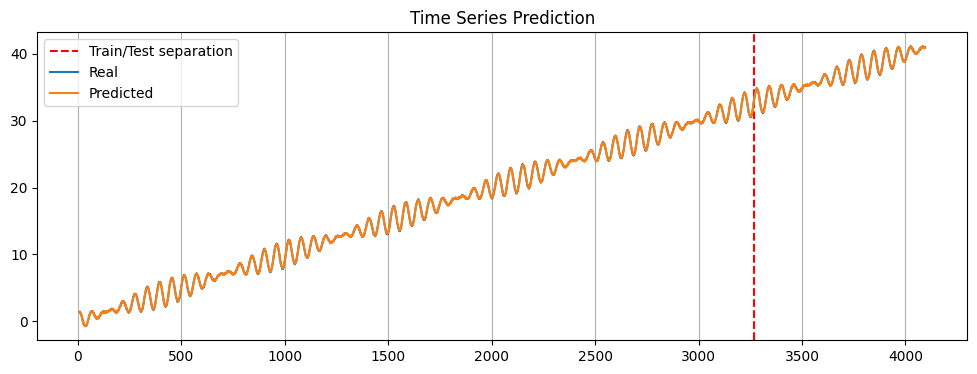

In [ ]:
rnn.eval()
train_predict_rnn, h = rnn(x.unsqueeze(2))
time_series_plot(train_predict_rnn)

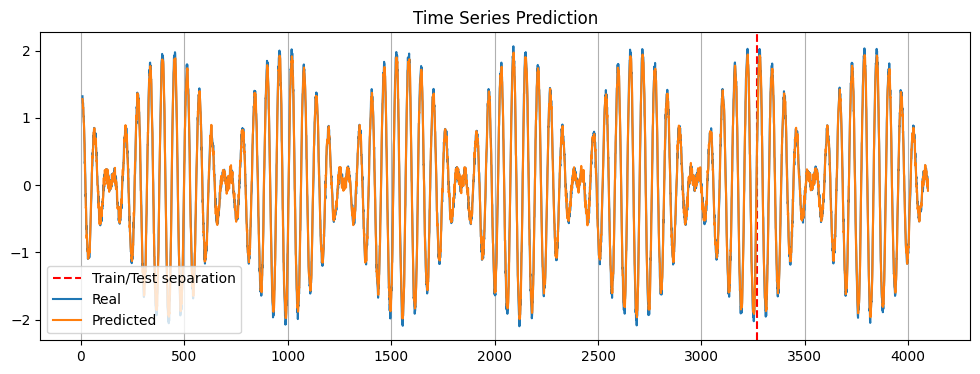

In [ ]:
time_series_plot_without_trend(train_predict_rnn)

In [ ]:
pred_rnn = train_predict_rnn.squeeze().detach().numpy()

mse_rnn = mean_squared_error(y, pred_rnn)
print("MSE RNN: " + str(mse_rnn))
mae_rnn = mean_absolute_error(y, pred_rnn)
print("MAE RNN: " + str(mae_rnn))
rmse_rnn = math.sqrt(mean_squared_error(y, pred_rnn))
print("RMSE RNN: " + str(rmse_rnn))

MSE RNN: 0.007960246
MAE RNN: 0.072542466
RMSE RNN: 0.08922021040414316


Теперь обучите на этих же данных LSTM с таким же размером скрытого слоя и визуализируйте результат.

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=2):
        # hidden_size == number of neurons
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Predict only one value

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        y = self.fc(h)
        return y, h

In [ ]:
%%time
print("Simple LSTM training process with MSE loss:")
my_lstm = MyLSTM(input_size, hidden_size=2)
time_series_train(my_lstm)

Simple LSTM training process with MSE loss:
Epoch: 0,       loss: 1.07063
Epoch: 100,     loss: 0.05744
Epoch: 200,     loss: 0.02163
Epoch: 300,     loss: 0.01537
Epoch: 400,     loss: 0.01294
Epoch: 500,     loss: 0.01139
Epoch: 600,     loss: 0.01000
Epoch: 700,     loss: 0.00898
Epoch: 800,     loss: 0.00811
Epoch: 900,     loss: 0.00762
Epoch: 1000,    loss: 0.00763
Epoch: 1100,    loss: 0.00711
Epoch: 1200,    loss: 0.00760
Epoch: 1300,    loss: 0.00683
Epoch: 1400,    loss: 0.00672
Epoch: 1500,    loss: 0.00664
Epoch: 1600,    loss: 0.00674
Epoch: 1700,    loss: 0.00648
Epoch: 1800,    loss: 0.00643
Epoch: 1900,    loss: 0.00636
CPU times: user 18.2 s, sys: 1.31 s, total: 19.6 s
Wall time: 19.8 s


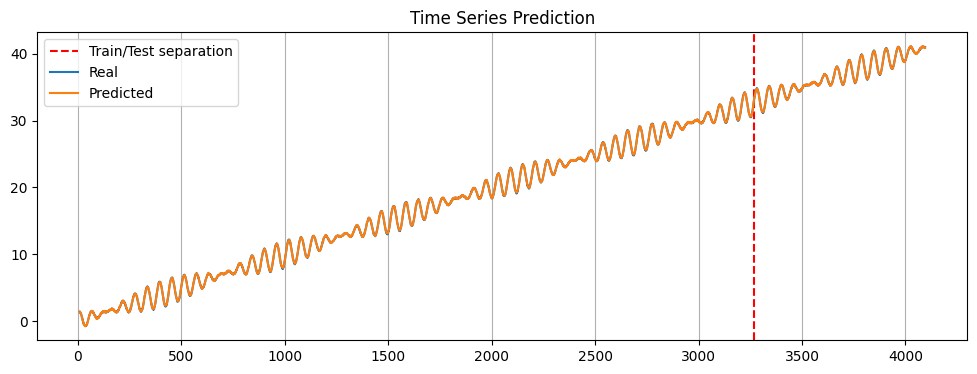

In [ ]:
my_lstm.eval()
train_predict_lstm, h = my_lstm(x.unsqueeze(2))
time_series_plot(train_predict_lstm)

In [ ]:
pred_lstm = train_predict_lstm.squeeze().detach().numpy()

mse_lstm = mean_squared_error(y, pred_lstm)
print("MSE LSTM: " + str(mse_lstm))
mae_lstm = mean_absolute_error(y, pred_lstm)
print("MAE LSTM: " + str(mae_lstm))
rmse_lstm = math.sqrt(mean_squared_error(y, pred_lstm))
print("RMSE LSTM: " + str(rmse_lstm))

MSE LSTM: 0.0062284423
MAE LSTM: 0.06429048
RMSE LSTM: 0.07892048088954062


Произведите аналогичные действия с GRU моделью.

In [ ]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size=2):
        # hidden_size == number of neurons
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Predict only one value

    def forward(self, x):
        out, h = self.gru(x)
        y = self.fc(h)
        return y, h

In [ ]:
%%time
print("Simple GRU training process with MSE loss:")
my_gru = MyGRU(input_size, hidden_size=2)
time_series_train(my_gru)

Simple GRU training process with MSE loss:
Epoch: 0,       loss: 0.84036
Epoch: 100,     loss: 0.03436
Epoch: 200,     loss: 0.02106
Epoch: 300,     loss: 0.01696
Epoch: 400,     loss: 0.01556
Epoch: 500,     loss: 0.01471
Epoch: 600,     loss: 0.01370
Epoch: 700,     loss: 0.01250
Epoch: 800,     loss: 0.01103
Epoch: 900,     loss: 0.00958
Epoch: 1000,    loss: 0.00872
Epoch: 1100,    loss: 0.00828
Epoch: 1200,    loss: 0.00793
Epoch: 1300,    loss: 0.00757
Epoch: 1400,    loss: 0.00700
Epoch: 1500,    loss: 0.00652
Epoch: 1600,    loss: 0.00633
Epoch: 1700,    loss: 0.00619
Epoch: 1800,    loss: 0.00608
Epoch: 1900,    loss: 0.00670
CPU times: user 20.2 s, sys: 81.5 ms, total: 20.3 s
Wall time: 20.3 s


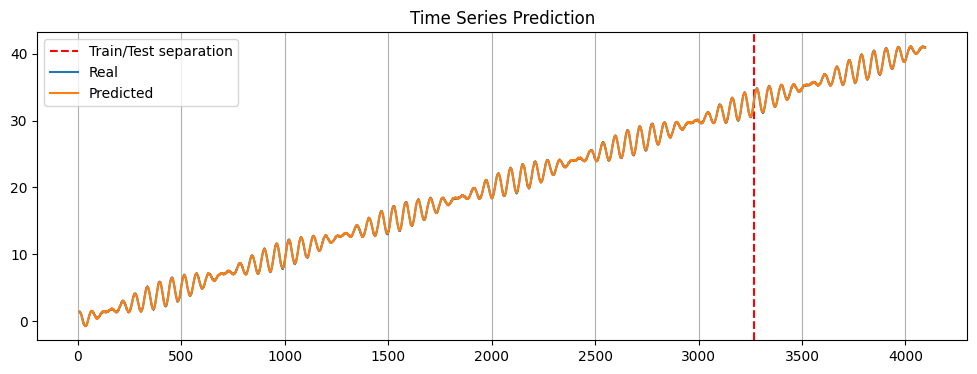

In [ ]:
my_gru.eval()
train_predict_gru, h = my_gru(x.unsqueeze(2))
time_series_plot(train_predict_gru)

In [ ]:
pred_gru = train_predict_gru.squeeze().detach().numpy()

mse_gru = mean_squared_error(y, pred_gru)
print("MSE GRU: " + str(mse_gru))
mae_gru = mean_absolute_error(y, pred_gru)
print("MAE GRU: " + str(mae_gru))
rmse_gru = math.sqrt(mean_squared_error(y, pred_gru))
print("RMSE GRU: " + str(rmse_gru))

MSE GRU: 0.005827699
MAE GRU: 0.062402938
RMSE GRU: 0.0763393663622654


In [ ]:
print('Метрики для всех моделей:')
print()
print("MSE RNN: " + str(mse_rnn))
print("MAE RNN: " + str(mae_rnn))
print("RMSE RNN: " + str(rmse_rnn))
print()
print("MSE LSTM: " + str(mse_lstm))
print("MAE LSTM: " + str(mae_lstm))
print("RMSE LSTM: " + str(rmse_lstm))
print()
print("MSE GRU: " + str(mse_gru))
print("MAE GRU: " + str(mae_gru))
print("RMSE GRU: " + str(rmse_gru))

Метрики для всех моделей:

MSE RNN: 0.007960246
MAE RNN: 0.072542466
RMSE RNN: 0.08922021040414316

MSE LSTM: 0.0062284423
MAE LSTM: 0.06429048
RMSE LSTM: 0.07892048088954062

MSE GRU: 0.005827699
MAE GRU: 0.062402938
RMSE GRU: 0.0763393663622654




Сравните результаты и скорость работы RNN, LSTM и GRU.

**Вывод: все архитектуры показали очень хорошие и почти одинаковые значения метрик. Это может быть связано с тем, что данные очень простые, эпох много, предсказания делали на всей генеральной выборке, и модели могли переобучиться. По скорости работы быстрее всего RNN (6.8 с против 17.8 с у LSTM и 22.7 с у GRU).**

## Формат результата

Графики предсказания RNN, LSTM, GRU.

Посчитанные метрики.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX09/result_1_task_ex09.png" width="800">

# Задание 2. Генерация фамилий

Возьмите следующий набор данных и, используя код из лекции, создайте реккурентную сеть для генерации фамилий. Для ускорения обучения перенесите данные и модель на видеокарту. Подумайте, как получить разные фамилии, начинающиеся на одну и ту же букву.

In [ ]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

set_random_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/surnames.txt

--2023-12-06 08:06:26--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/surnames.txt
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 759340 (742K) [text/plain]
Saving to: ‘surnames.txt’

surnames.txt        100%[===================>] 741.54K  1.04MB/s    in 0.7s    

2023-12-06 08:06:28 (1.04 MB/s) - ‘surnames.txt’ saved [759340/759340]



In [ ]:
with open("surnames.txt", encoding="utf-8") as s_file:
    surnames_list = [line.strip().lower() for line in s_file.readlines()]
    surnames_list.append(' ')

In [ ]:
print(surnames_list)

['иванов', 'кузнецов', 'попов', 'смирнов', 'иванова', 'васильев', 'петров', 'кузнецова', 'волков', 'соколов', 'козлов', 'новиков', 'морозов', 'павлов', 'михайлов', 'федоров', 'смирнова', 'степанов', 'семенов', 'макаров', 'егоров', 'алексеев', 'андреев', 'попова', 'захаров', 'николаев', 'васильева', 'зайцев', 'яковлев', 'романов', 'никитин', 'лебедев', 'петрова', 'сергеев', 'борисов', 'орлов', 'григорьев', 'соловьев', 'киселев', 'кузьмин', 'тарасов', 'воробьев', 'фролов', 'медведев', 'шевченко', 'сорокин', 'жуков', 'ковалев', 'бондаренко', 'баранов', 'поляков', 'филиппов', 'белов', 'дмитриев', 'мельников', 'гусев', 'соколова', 'максимов', 'волкова', 'александров', 'новикова', 'антонов', 'павлова', 'морозова', 'ильин', 'сидоров', 'михайлова', 'матвеев', 'коваленко', 'богданов', 'куликов', 'данилов', 'калинин', 'федорова', 'осипов', 'пономарев', 'макарова', 'назаров', 'власов', 'андреева', 'гаврилов', 'колесников', 'тимофеев', 'семенова', 'миронов', 'беляев', 'захарова', 'алексеева', 'али

In [ ]:
len(surnames_list)

46241

In [ ]:
# Your code here

In [ ]:
import pprint

text = surnames_list

# Join all the sentences together and extract the unique characters
# from the combined sentences
chars = set("".join(text))
# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}
#char2int[' '] = 34
print("Dictionary for mapping character to the integer:")
pprint.pprint(char2int)

Dictionary for mapping character to the integer:
{' ': 32,
 'а': 11,
 'б': 21,
 'в': 24,
 'г': 27,
 'д': 31,
 'е': 15,
 'ж': 18,
 'з': 8,
 'и': 3,
 'й': 19,
 'к': 14,
 'л': 22,
 'м': 0,
 'н': 4,
 'о': 1,
 'п': 9,
 'р': 16,
 'с': 6,
 'т': 23,
 'у': 17,
 'ф': 7,
 'х': 26,
 'ц': 5,
 'ч': 30,
 'ш': 20,
 'щ': 12,
 'ъ': 2,
 'ы': 29,
 'ь': 10,
 'э': 13,
 'ю': 28,
 'я': 25,
 'ё': 33}


In [ ]:
lengths = [len(sent) for sent in text]
maxlen = max(lengths)
print(f"The longest string has {maxlen} characters.\n")

print(f"Initial texts:\n{text}")
# A simple loop that loops through the list of sentences and adds
# a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i]) < maxlen:
        text[i] += " "

print(f"Resulting texts:\n{text}")

The longest string has 11 characters.

Initial texts:
['иванов', 'кузнецов', 'попов', 'смирнов', 'иванова', 'васильев', 'петров', 'кузнецова', 'волков', 'соколов', 'козлов', 'новиков', 'морозов', 'павлов', 'михайлов', 'федоров', 'смирнова', 'степанов', 'семенов', 'макаров', 'егоров', 'алексеев', 'андреев', 'попова', 'захаров', 'николаев', 'васильева', 'зайцев', 'яковлев', 'романов', 'никитин', 'лебедев', 'петрова', 'сергеев', 'борисов', 'орлов', 'григорьев', 'соловьев', 'киселев', 'кузьмин', 'тарасов', 'воробьев', 'фролов', 'медведев', 'шевченко', 'сорокин', 'жуков', 'ковалев', 'бондаренко', 'баранов', 'поляков', 'филиппов', 'белов', 'дмитриев', 'мельников', 'гусев', 'соколова', 'максимов', 'волкова', 'александров', 'новикова', 'антонов', 'павлова', 'морозова', 'ильин', 'сидоров', 'михайлова', 'матвеев', 'коваленко', 'богданов', 'куликов', 'данилов', 'калинин', 'федорова', 'осипов', 'пономарев', 'макарова', 'назаров', 'власов', 'андреева', 'гаврилов', 'колесников', 'тимофеев', 'семенов

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])

    # Remove first character for target sequence
    target_seq.append(text[i][1:])

In [ ]:
len(text)

46241

In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [ ]:
import numpy as np

dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)


def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)

    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features


input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print(
    "Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(
        input_seq.shape
    )
)
print(input_seq[0])

Input shape: (46241, 10, 34) --> (Batch Size, Sequence Length, One-Hot Encoding Size)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
# Convert data to tensor
import torch

input_seq = torch.Tensor(input_seq).to(device)
target_seq = torch.Tensor(target_seq).to(device)

In [ ]:
import torch.nn as nn


class NextCharacterGenerator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size=hidden_dim, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden_0 = torch.zeros(
            1, batch_size, self.rnn.hidden_size
        ).to(device)  # 1 correspond to number of layers

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden_0)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        # Need Only if n_layers > 1
        out = out.contiguous().view(-1, self.rnn.hidden_size)
        out = self.fc(out)

        return out, hidden

In [ ]:
# Instantiate the model with hyperparameters
model = NextCharacterGenerator(
    input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1
).to(device)

if torch.cuda.is_available():
   model.cuda()
   input_seq = input_seq.cuda()
   target_seq = target_seq.cuda()

In [ ]:
# Instantiate the model with hyperparameters
model = NextCharacterGenerator(
    input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1
).to(device)

if torch.cuda.is_available():
   model.cuda()
   input_seq = input_seq.cuda()
   target_seq = target_seq.cuda()

# Define hyperparameters
num_epochs = 250

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Run
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()  # Clears existing gradients from previous epoch
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()  # Does backpropagation and calculates gradients
    optimizer.step()  # Updates the weights accordingly

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}".ljust(20), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/250        Loss: 2.8757
Epoch: 20/250        Loss: 2.5347
Epoch: 30/250        Loss: 2.3613
Epoch: 40/250        Loss: 2.1686
Epoch: 50/250        Loss: 2.0113
Epoch: 60/250        Loss: 1.8957
Epoch: 70/250        Loss: 1.8133
Epoch: 80/250        Loss: 1.7560
Epoch: 90/250        Loss: 1.7162
Epoch: 100/250       Loss: 1.6872
Epoch: 110/250       Loss: 1.6648
Epoch: 120/250       Loss: 1.6468
Epoch: 130/250       Loss: 1.6318
Epoch: 140/250       Loss: 1.6190
Epoch: 150/250       Loss: 1.6078
Epoch: 160/250       Loss: 1.5980
Epoch: 170/250       Loss: 1.5894
Epoch: 180/250       Loss: 1.5818
Epoch: 190/250       Loss: 1.5749
Epoch: 200/250       Loss: 1.5686
Epoch: 210/250       Loss: 1.5627
Epoch: 220/250       Loss: 1.5571
Epoch: 230/250       Loss: 1.5518
Epoch: 240/250       Loss: 1.5467
Epoch: 250/250       Loss: 1.5419


In [ ]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)

    out, hidden = model(character)
    # print(out.shape)
    # print(out)
    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden


def sample(model, out_len, start="л"):
    model.eval()  # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for _ in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return "".join(chars)


sample(model.to(device), 7, "л")

'ларова '

In [ ]:
list_prohibited = [' ', 'ъ', 'ь', 'ы', 'й']
for key in char2int:
    if not key in list_prohibited:
      print(sample(model, 10, key))

марова    
ованов    
инова     
нарова    
церева    
сарова    
фарова    
зарова    
парова    
арован    
щерева    
эрова     
корова    
еванов    
рарова    
урова     
жерова    
шерева    
барова    
ларова    
тарова    
варова    
ярова     
харова    
гарова    
юлин      
черенков  
дарова    
ёва       


Определим функцию sample_couple, которая будет выдавать несколько фамилий, начинающихся на одну и ту же букву, по убыванию вероятности предсказания.

In [ ]:
def predict_couple(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)

    out, hidden = model(character)
    prob = nn.functional.softmax(out[-1], dim=0).data
    sorted_prob = torch.argsort(prob, descending=True)
    # Taking number of the classes, equal to num_examples, with the highest probability score from the output
    return [int2char[sorted_prob[i].item()] for i in range(len(sorted_prob))], hidden



def sample_couple(model, out_len, num_examples, start):
    model.eval()  # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [[ch for ch in start] for _ in range(num_examples)]
    size = out_len - len(start)
    # Now pass in the previous characters and get a new one
    for j in range(num_examples):
        for i in range(size):
            char, h = predict_couple(model, chars[j])
            chars[j].append(char[j if i == 0 else 0])
        print("".join(chars[j]))


In [ ]:
sample_couple(model, out_len=8, num_examples=7, start="л")

ларова  
лован   
линов   
леренков
лурова  
льков   
лытов   


## Формат результата

Модель генерирующая фамилии по первой букве.

Пример:

а — Аркова

б — Банова

в — Варенков

г — Гаранков

**Вывод: интересное задание на генерацию разных фамилий.**

**Вывод 2: генерировать список в списке умножением нулевого элемента n раз - очень плохая идея**

# Задание 3. Прогнозирование многомерного временного ряда.

Попробуйте свои силы в анализе многомерных данных. Особенностью таких задач является то, что признаки не являются независимыми и разумно анализировать их одновременно.

В качестве датасета предлагаем [курс биткоина](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1642118400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) за не менее чем 3 года.


Рекомендуем использовать модель LSTM.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']= 200

import torch.nn as nn

import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

Загрузка даннных и разведовательный анализ

In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/BTC-USD.csv

--2023-12-06 20:18:10--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/BTC-USD.csv
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186770 (182K) [application/octet-stream]
Saving to: ‘BTC-USD.csv.1’

BTC-USD.csv.1       100%[===================>] 182.39K  --.-KB/s    in 0.01s   

2023-12-06 20:18:10 (12.8 MB/s) - ‘BTC-USD.csv.1’ saved [186770/186770]



In [ ]:
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

Open          High           Low         Close  \
Date                                                                 
2017-11-29  10077.400391  11517.400391   9601.030273   9888.610352   
2017-11-30   9906.790039  10801.000000   9202.049805  10233.599609   
2017-12-01  10198.599609  11046.700195   9694.650391  10975.599609   
2017-12-02  10978.299805  11320.200195  10905.099609  11074.599609   
2017-12-03  11082.700195  11858.700195  10862.000000  11323.200195   

                 Volume  
Date                     
2017-11-29  11568799744  
2017-11-30   8310689792  
2017-12-01   6783119872  
2017-12-02   5138500096  
2017-12-03   6608309760

In [ ]:
df.describe()

Open          High           Low         Close        Volume
count   2173.000000   2173.000000   2173.000000   2173.000000  2.173000e+03
mean   21206.673715  21704.334543  20663.812906  21217.163404  2.511005e+10
std    15831.294062  16228.841891  15378.668660  15829.346577  1.879618e+10
min     3236.274658   3275.377930   3191.303467   3236.761719  2.923670e+09
25%     8305.134766   8497.692383   8125.431641   8294.309570  1.203664e+10
50%    16602.269531  16807.527344  16320.634766  16604.464844  2.217768e+10
75%    30274.320313  30664.976563  29679.158203  30295.806641  3.377345e+10
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11

У нас есть ежедневные исторические данные о ценах:

* Цена открытия
* Верхняя цена
* Нижняя цена
* Объем торгов

Наша цель — взять некоторую последовательность из четырех вышеуказанных значений (скажем, за 100 предыдущих дней) и спрогнозировать целевую переменную на следующие 50 дней в будущем.

Визуализируем целевую переменную.

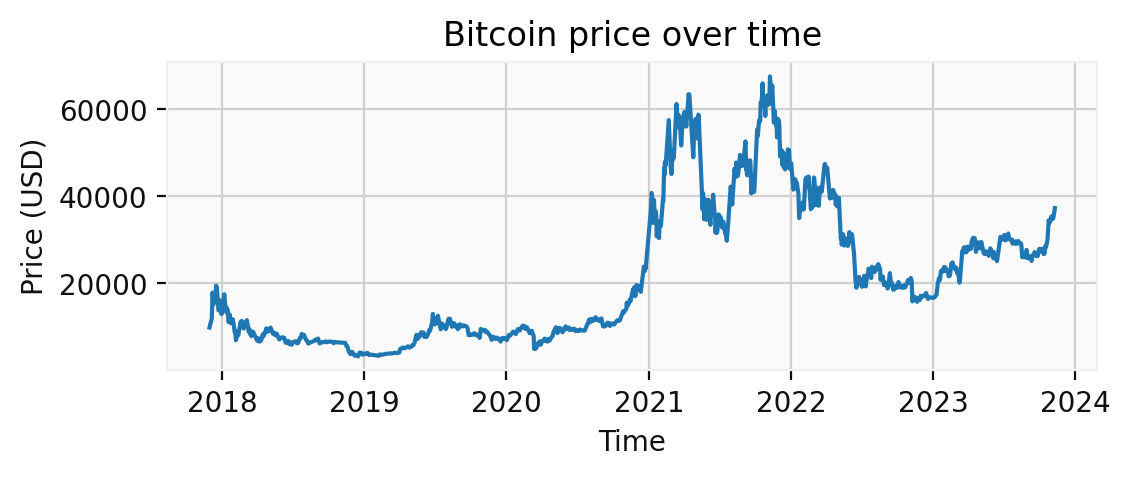

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,2)

plt.plot(df['Close'])
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

Давайте выведим график в более симпатичном виде.

In [ ]:
!pip install mplfinance

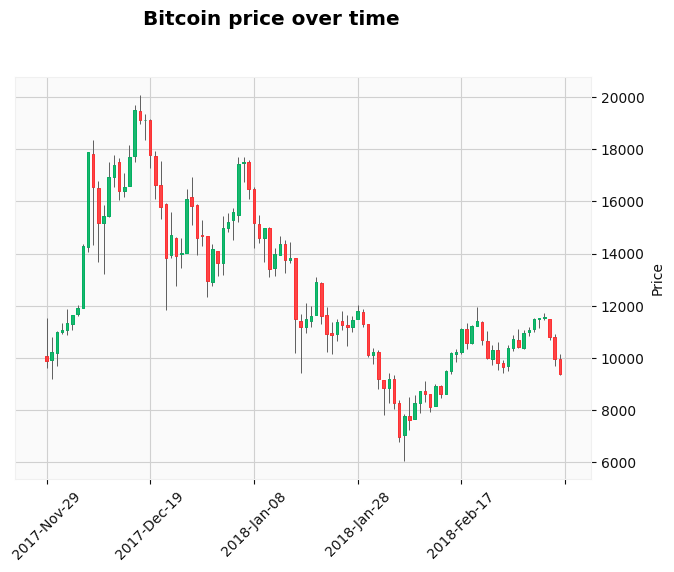

In [ ]:
import mplfinance as mpf

mpf.plot(df[:100], type='candle', style='yahoo', title='Bitcoin price over time')

Выделим признаки и целевую переменную.
Здесь представлена относительно небольшая часть данных.

In [ ]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((2173, 4), (2173,))

**Нормировка**

Явного тренда не наблюдается. Поэтому только стандартизуем признаки.
Целевая переменная также варьируется в широком диапазоне.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # Your code here
# Your code here
ss = StandardScaler()
mm = MinMaxScaler()
X_trans = mm.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))# Your code here

In [ ]:
X_trans

array([[0.1063716 , 0.12580504, 0.10143456, 0.02483917],
       [0.10371881, 0.11487001, 0.09512065, 0.01547797],
       [0.10825611, 0.11862034, 0.10291611, 0.01108896],
       ...,
       [0.50041161, 0.4994187 , 0.50571472, 0.04129281],
       [0.50374149, 0.52890602, 0.51274583, 0.10009934],
       [0.52035725, 0.52230506, 0.52494148, 0.05685367]])

In [ ]:
y_trans

array([[0.10340186],
       [0.10876466],
       [0.12029893],
       ...,
       [0.50394034],
       [0.52007351],
       [0.52972442]])

Требуется подать в модель 100 значений до текущего дня и спрогнозировать следующие 50 значений временного шага.

Требуется получать 100 выборок из X, брать 50 следующих индексов в y и их объединять. Обратите внимание, что из-за этого требуется выбросить первые 50 значений y.

In [ ]:
# split a multivariate sequence into samples
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    # Your code here
    #out_end_index = 0
    #while out_end_index < len(input_sequences):
    for i in range(len(input_sequences)):
        in_end_index = n_steps_in + i
        out_end_index = in_end_index + n_steps_out - 1
        if out_end_index > len(input_sequences): break
        seq_x, seq_y = input_sequences[i:in_end_index], output_sequence[in_end_index - 1: out_end_index, -1]
        X.append(seq_x), y.append(seq_y)
    # Your code here
    return np.array(X), np.array(y)

In [ ]:
X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(2025, 100, 4) (2025, 50)


Давайте проверим, что первая выборка в y_mm действительно начинается с сотой выборки в исходном целевом векторе y.

In [ ]:
y_mm[0]

array([0.09572892, 0.09483572, 0.08750556, 0.09858327, 0.09277712,
       0.09261747, 0.07823788, 0.07872056, 0.07930332, 0.07275165,
       0.0775208 , 0.08384709, 0.08824347, 0.08848924, 0.08536767,
       0.08771728, 0.08442955, 0.08175055, 0.07729883, 0.07144837,
       0.07333613, 0.06107468, 0.05679705, 0.05808743, 0.05607748,
       0.05980156, 0.06558905, 0.05622687, 0.05556824, 0.05284556,
       0.05711681, 0.05886452, 0.05493494, 0.05593027, 0.05800644,
       0.07232214, 0.07242645, 0.07382984, 0.0791597 , 0.07495575,
       0.07252174, 0.07658407, 0.07861873, 0.08719202, 0.08796537,
       0.08651784, 0.0885141 , 0.10043108, 0.08719062, 0.09396459])

In [ ]:
y_trans[99:149].squeeze(1)

array([0.09572892, 0.09483572, 0.08750556, 0.09858327, 0.09277712,
       0.09261747, 0.07823788, 0.07872056, 0.07930332, 0.07275165,
       0.0775208 , 0.08384709, 0.08824347, 0.08848924, 0.08536767,
       0.08771728, 0.08442955, 0.08175055, 0.07729883, 0.07144837,
       0.07333613, 0.06107468, 0.05679705, 0.05808743, 0.05607748,
       0.05980156, 0.06558905, 0.05622687, 0.05556824, 0.05284556,
       0.05711681, 0.05886452, 0.05493494, 0.05593027, 0.05800644,
       0.07232214, 0.07242645, 0.07382984, 0.0791597 , 0.07495575,
       0.07252174, 0.07658407, 0.07861873, 0.08719202, 0.08796537,
       0.08651784, 0.0885141 , 0.10043108, 0.08719062, 0.09396459])

In [ ]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

Будем предсказывать данные на несколько месяцев вперед.

Возьмём для обучения 90% данных, на тест - 10%. Как раз их и требуется предсказать.

In [ ]:
# Your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.1, shuffle=False, random_state=42)

In [ ]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (1822, 100, 4) (1822, 50)
Testing Shape: (203, 100, 4) (203, 50)


Переведём данные в тензоры для подачи в модель.

In [ ]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [ ]:
print(X_train_tensors.shape)
print(X_test_tensors.shape)
print(y_train_tensors.shape)
print(y_test_tensors.shape)

torch.Size([1822, 100, 4])
torch.Size([203, 100, 4])
torch.Size([1822, 50])
torch.Size([203, 50])


В зависимости от того, как вы организуете данные и модель, вам может потребоваться привести данные к такой форме, которую сможет принять модель. Используйте torch.reshape

In [ ]:
# reshaping to rows, timestamps, features
# Your code here

In [ ]:
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

**Модель LSTM**

Вы можете реализовать модель как через слой `LSTM`, так и через `LSTMCell`.

Возможно, вам будет полезен параметр `dropout` в этих слоях.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        # Your code here
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 256)
        self.fc_2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Your code here
        h_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (h_n, c_n) = self.lstm(x, (h_t, c_t))
        h_n = h_n.view(-1, self.hidden_size)
        out = self.relu(h_n)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)

        return out

**Обучение**

Реализуйте цикл обучения.

В качестве loss-функции вы можете использовать как обычный MSE, так и что-то более подходящее на ваш взгляд.

In [ ]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        output = lstm.forward(X_train)
        optimiser.zero_grad()
        output = lstm.forward(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimiser.step()

        lstm.eval()
        test_pred = lstm(X_test)
        test_loss = loss_fn(test_pred, y_test)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}/{n_epochs}".ljust(20), end=" ")
            print(f'Loss: {loss.item():.4f}')
            print(f'Test Loss: {test_loss.item():.4f}')

Задайте параметры сети.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # Your code here

# Your code here
input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes

# Your code here
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

Задайте loss-функцию и оптимизатор. Отметьте, что вам нужен loss для регрессии.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
loss_fn = nn.MSELoss()# Your code here
optimiser = optim.Adam(lstm.parameters(), lr=0.001)# Your code here

Запустите цикл обучения

In [ ]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors,
              y_train=y_train_tensors,
              X_test=X_test_tensors,
              y_test=y_test_tensors)

Epoch: 0/1000        Loss: 0.1698
Test Loss: 0.1449
Epoch: 100/1000      Loss: 0.0105
Test Loss: 0.0207
Epoch: 200/1000      Loss: 0.0063
Test Loss: 0.0018
Epoch: 300/1000      Loss: 0.0061
Test Loss: 0.0018
Epoch: 400/1000      Loss: 0.0060
Test Loss: 0.0019
Epoch: 500/1000      Loss: 0.0060
Test Loss: 0.0019
Epoch: 600/1000      Loss: 0.0059
Test Loss: 0.0020
Epoch: 700/1000      Loss: 0.0058
Test Loss: 0.0020
Epoch: 800/1000      Loss: 0.0057
Test Loss: 0.0021
Epoch: 900/1000      Loss: 0.0056
Test Loss: 0.0021


**Предсказание**

Обратите внимание на то, что вы передаёте в модель. И так ли эти данные выглядят, как те, на которых модель училась.

Постройте график предсказания для всего набора данных.

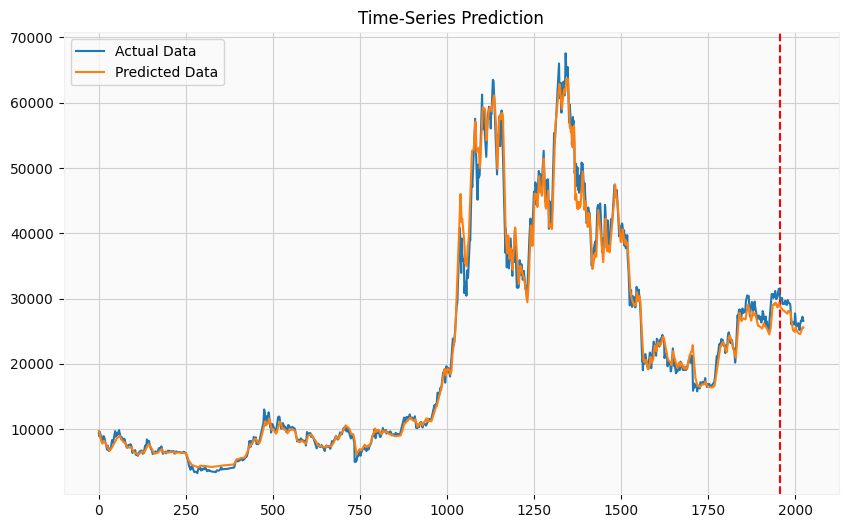

In [ ]:
df_X_ss = mm.fit_transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.fit_transform(df.Close.values.reshape(-1, 1)) # old transformers

# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50) # Your code here

# converting to tensors
df_X_ss = torch.Tensor(df_X_ss) # Your code here
df_y_mm = torch.Tensor(df_y_mm) # Your code here

# reshaping the dataset
#df_X_ss = # Your code here

# forward pass
train_predict = lstm(df_X_ss) # Your code here
data_predict = train_predict.data.numpy()# Your code here
dataY_plot = df_y_mm.data.numpy() # Your code here


data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x = 0.9*len(X), c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

Как вам результат?

Если вы подали достаточно данных, и если смотрите не слишком далеко за красную линию, вы должны увидеть, что **ваша модель удивительно точна** в прогнозировании цены на несколько месяцев вперед.


Однако то, что здесь происходит, является **утечкой данных**: информация о таргетах просочилась в тестовые признаки.


 То есть всякий раз, когда мы запускаем модель, она имеет доступ к цене открытия на этот день, которая, очевидно, будет очень близка к цене в конечном итоге для этого конкретного временного шага. Когда мы перебираем наши прогнозы по модели, мы добавляем первое предсказанное значение для этого временного шага. Это означает, что каждое предсказание, которое мы здесь строим, имеет то преимущество, что оно является следующим предсказанным значением, а не последовательностью из 50 значений в будущем.

**Как надо:** передать 100 временных шагов перед последним значением в тесте, а затем использовать **один раз** `forward` модели, чтобы предсказать следующие 50 временных шагов.

In [ ]:
test_predict = lstm(X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

In [ ]:
X_test_tensors[-1].shape

torch.Size([100, 4])

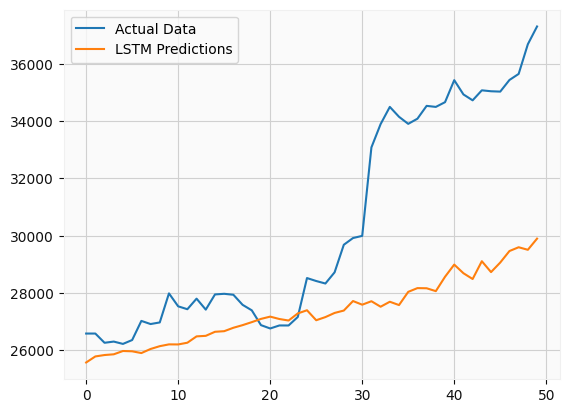

In [ ]:
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.legend()
plt.savefig("small_plot.png", dpi=300)
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_target, test_predict)
print("MSE: " + str(mse))
mae = mean_absolute_error(test_target, test_predict)
print("MAE: " + str(mae))
rmse = math.sqrt(mean_squared_error(test_target, test_predict))
print("RMSE: " + str(rmse))

MSE: 16010636.84935814
MAE: 3008.8297265625
RMSE: 4001.3293852616207


Хорошим результатом будет является, если реальные и предсказанные значения имеют один тренд.


В качестве последнего графика давайте посмотрим на масштаб данных.

**Настройте этот масштаб под ваши данные!**

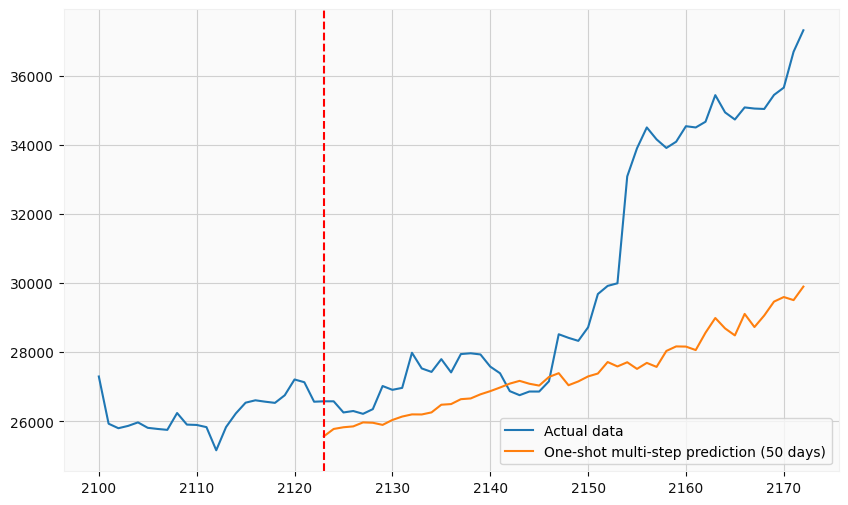

In [ ]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2100, len(y))]
plt.plot(a, y[2100:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.savefig("final_plot.png", dpi=300)
plt.show()

Ваш результат отчётливо зависит от того среда от данных, который вы используете.

Т.е. от того, не поменял ли ряд свой профиль после красной линии.



**Дополнительно**

* Взять больше исторических данных и попробовать улучшить свою модель. А также проверить её на различных участках ряда.

* Реализовать кросс-валидацию на временных рядах

## Формат результата

График с предсказанием, численная метрика оценки качества предсказания



<center><img src ="https://imageup.ru/img145/4642815/ts_prediction.png" width="500"></center>

**Вывод: значения метрик неприлично большие, в силу резкого подъема цены биткоина на том отрезке времени, который хотим предсказать, хотя модель и смогла определить верный тренд роста цены.**

# Задание 4*. Посимвольная генерация текста

Возьмите произведение Гете "Фауст" и обучите на нем LSTM модель для посимвольной генерации текста. Вместо one-hot кодирования используйте `nn.Embedding` [ссылка](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) [ссылка](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html). При обучении игнорируйте знаки препинания и номера страниц.


In [ ]:
import math
import random
from collections import Counter

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
set_random_seed(42)

Using device: cuda


In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Faust.txt

--2023-12-07 14:08:55--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Faust.txt
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666546 (651K) [text/plain]
Saving to: ‘Faust.txt’

Faust.txt           100%[===================>] 650.92K   894KB/s    in 0.7s    

2023-12-07 14:08:57 (894 KB/s) - ‘Faust.txt’ saved [666546/666546]



In [ ]:
with open("Faust.txt") as text_file:
    faust_text = "".join(text_file.readlines())

In [ ]:
faust_text

'вы вновь со мной, туманные виденья,\nмне в юности мелькнувшие давно…\nвас удержу ль во власти вдохновенья?\nбылым ли снам явиться вновь дано?\nиз сумрака, из тьмы полузабвенья\nвосстали вы… о, будь, что суждено!\nкак в юности, ваш вид мне грудь волнует,\nи дух мой снова чары ваши чует.\nвы принесли с собой воспоминанье\nвеселых дней и милых теней рой;\nвоскресло вновь забытое сказанье\nлюбви и дружбы первой предо мной;\nвсе вспомнилось: и прежнее страданье,\nи жизни бег запутанной чредой,\nи образы друзей, из жизни юной\nисторгнутых, обманутых фортуной.\nкому я пел когда-то, вдохновенный,\nтем песнь моя – увы! – уж не слышна…\nкружок друзей рассеян по вселенной,\nих отклик смолк, прошли те времена.\nя чужд толпе со скорбью, мне священной,\nмне самая хвала ее страшна,\nа те, кому моя звучала лира,\nкто жив еще, – рассеяны средь мира.\nи вот воскресло давнее стремленье\nтуда, в мир духов, строгий и немой,\nи робкое родится песнопенье,\nстеня, дрожа эоловой струной;\nв суровом сердце тре

In [ ]:
len(faust_text)

372321

In [ ]:
faust_text_sp = faust_text.split('\n')
faust_text_sp1 = [faust_text_sp[i].split(' ') for i in range(len(faust_text_sp))]
print(faust_text_sp1)

[['вы', 'вновь', 'со', 'мной,', 'туманные', 'виденья,'], ['мне', 'в', 'юности', 'мелькнувшие', 'давно…'], ['вас', 'удержу', 'ль', 'во', 'власти', 'вдохновенья?'], ['былым', 'ли', 'снам', 'явиться', 'вновь', 'дано?'], ['из', 'сумрака,', 'из', 'тьмы', 'полузабвенья'], ['восстали', 'вы…', 'о,', 'будь,', 'что', 'суждено!'], ['как', 'в', 'юности,', 'ваш', 'вид', 'мне', 'грудь', 'волнует,'], ['и', 'дух', 'мой', 'снова', 'чары', 'ваши', 'чует.'], ['вы', 'принесли', 'с', 'собой', 'воспоминанье'], ['веселых', 'дней', 'и', 'милых', 'теней', 'рой;'], ['воскресло', 'вновь', 'забытое', 'сказанье'], ['любви', 'и', 'дружбы', 'первой', 'предо', 'мной;'], ['все', 'вспомнилось:', 'и', 'прежнее', 'страданье,'], ['и', 'жизни', 'бег', 'запутанной', 'чредой,'], ['и', 'образы', 'друзей,', 'из', 'жизни', 'юной'], ['исторгнутых,', 'обманутых', 'фортуной.'], ['кому', 'я', 'пел', 'когда-то,', 'вдохновенный,'], ['тем', 'песнь', 'моя', '–', 'увы!', '–', 'уж', 'не', 'слышна…'], ['кружок', 'друзей', 'рассеян', 'по',

In [ ]:
from itertools import chain
faust_text_sp = list(chain.from_iterable(faust_text_sp1))
faust_text_sp

['вы',
 'вновь',
 'со',
 'мной,',
 'туманные',
 'виденья,',
 'мне',
 'в',
 'юности',
 'мелькнувшие',
 'давно…',
 'вас',
 'удержу',
 'ль',
 'во',
 'власти',
 'вдохновенья?',
 'былым',
 'ли',
 'снам',
 'явиться',
 'вновь',
 'дано?',
 'из',
 'сумрака,',
 'из',
 'тьмы',
 'полузабвенья',
 'восстали',
 'вы…',
 'о,',
 'будь,',
 'что',
 'суждено!',
 'как',
 'в',
 'юности,',
 'ваш',
 'вид',
 'мне',
 'грудь',
 'волнует,',
 'и',
 'дух',
 'мой',
 'снова',
 'чары',
 'ваши',
 'чует.',
 'вы',
 'принесли',
 'с',
 'собой',
 'воспоминанье',
 'веселых',
 'дней',
 'и',
 'милых',
 'теней',
 'рой;',
 'воскресло',
 'вновь',
 'забытое',
 'сказанье',
 'любви',
 'и',
 'дружбы',
 'первой',
 'предо',
 'мной;',
 'все',
 'вспомнилось:',
 'и',
 'прежнее',
 'страданье,',
 'и',
 'жизни',
 'бег',
 'запутанной',
 'чредой,',
 'и',
 'образы',
 'друзей,',
 'из',
 'жизни',
 'юной',
 'исторгнутых,',
 'обманутых',
 'фортуной.',
 'кому',
 'я',
 'пел',
 'когда-то,',
 'вдохновенный,',
 'тем',
 'песнь',
 'моя',
 '–',
 'увы!',
 '–

In [ ]:
faust_text_sp.append(' ')

In [ ]:
len(faust_text_sp)

63672

In [ ]:
type(faust_text_sp)

list

In [ ]:
import pprint

# Join all the sentences together and extract the unique characters
# from the combined sentences
chars = set("".join(faust_text_sp))
# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

print("Dictionary for mapping character to the integer:")
pprint.pprint(char2int)

Dictionary for mapping character to the integer:
{' ': 39,
 '!': 29,
 ',': 5,
 '-': 6,
 '.': 13,
 ':': 40,
 ';': 18,
 '?': 30,
 '«': 4,
 '»': 15,
 'а': 2,
 'б': 31,
 'в': 38,
 'г': 10,
 'д': 36,
 'е': 11,
 'ж': 42,
 'з': 9,
 'и': 0,
 'й': 28,
 'к': 16,
 'л': 25,
 'м': 19,
 'н': 21,
 'о': 14,
 'п': 22,
 'р': 24,
 'с': 7,
 'т': 32,
 'у': 33,
 'ф': 8,
 'х': 44,
 'ц': 1,
 'ч': 34,
 'ш': 17,
 'щ': 20,
 'ъ': 26,
 'ы': 37,
 'ь': 12,
 'э': 41,
 'ю': 3,
 'я': 35,
 'ё': 23,
 '–': 27,
 '…': 43}


In [ ]:
lengths = [len(sent) for sent in faust_text_sp]
maxlen = max(lengths)

print(f"The longest string has {maxlen} characters.\n")

# A simple loop that loops through the list of sentences and adds
# a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(faust_text_sp)):
    while len(faust_text_sp[i]) < maxlen:
        faust_text_sp[i] += " "

print(f"Resulting texts:\n{faust_text_sp}")

The longest string has 21 characters.

Resulting texts:
['вы                   ', 'вновь                ', 'со                   ', 'мной,                ', 'туманные             ', 'виденья,             ', 'мне                  ', 'в                    ', 'юности               ', 'мелькнувшие          ', 'давно…               ', 'вас                  ', 'удержу               ', 'ль                   ', 'во                   ', 'власти               ', 'вдохновенья?         ', 'былым                ', 'ли                   ', 'снам                 ', 'явиться              ', 'вновь                ', 'дано?                ', 'из                   ', 'сумрака,             ', 'из                   ', 'тьмы                 ', 'полузабвенья         ', 'восстали             ', 'вы…                  ', 'о,                   ', 'будь,                ', 'что                  ', 'суждено!             ', 'как                  ', 'в                    ', 'юности,              ', 'ваш              

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(faust_text_sp)):
    # Remove last character for input sequence
    input_seq.append(faust_text_sp[i][:-1])

    # Remove first character for target sequence
    target_seq.append(faust_text_sp[i][1:])

    #print("Input sequence:".ljust(18), f"'{input_seq[i]}'")
    #print("Target sequence:".ljust(18), f"'{target_seq[i]}'")
    #print()

In [ ]:
for i in range(len(faust_text_sp)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

    #print("Encoded input sequence:".ljust(25), input_seq[i])
    #print("Encoded target sequence:".ljust(25), target_seq[i])
    #print()

In [ ]:
len(input_seq)

63672

In [ ]:
import torch

input_seq = torch.Tensor(input_seq).to(torch.int64).to(device)
target_seq = torch.Tensor(target_seq).to(torch.int64).to(device)

In [ ]:
input_seq.shape

torch.Size([63672, 20])

In [ ]:
target_seq.shape

torch.Size([63672, 20])

In [ ]:
import torch.nn as nn


class LSTMFaust(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers=1):
        super().__init__()

        # Embedding Layer
        self.word_embedding = nn.Embedding(num_embeddings=len(char2int), embedding_dim=embed_len)
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, len(char2int))

    def forward(self, X_batch):
        embeddings = self.word_embedding(X_batch)

        hidden, carry = torch.randn(1, len(X_batch), hidden_dim).to(device), torch.randn(1, len(X_batch), hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))

        out = output.contiguous().view(-1, hidden_dim)
        out = self.fc(out)

        return out, hidden

        #return self.linear(output[:,-1])

In [ ]:
# Instantiate the model with hyperparameters
embed_len = maxlen
hidden_dim=12
model = LSTMFaust(
    input_size=len(char2int), hidden_dim=12, num_layers=1
).to(device)

if torch.cuda.is_available():
   model.cuda()
   input_seq = input_seq.cuda()
   target_seq = target_seq.cuda()

# Define hyperparameters
num_epochs = 250

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Run
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()  # Clears existing gradients from previous epoch
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()  # Does backpropagation and calculates gradients
    optimizer.step()  # Updates the weights accordingly

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}".ljust(20), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/250        Loss: 2.5380
Epoch: 20/250        Loss: 1.2102
Epoch: 30/250        Loss: 0.9504
Epoch: 40/250        Loss: 0.8318
Epoch: 50/250        Loss: 0.7875
Epoch: 60/250        Loss: 0.7511
Epoch: 70/250        Loss: 0.7255
Epoch: 80/250        Loss: 0.7052
Epoch: 90/250        Loss: 0.6889
Epoch: 100/250       Loss: 0.6762
Epoch: 110/250       Loss: 0.6657
Epoch: 120/250       Loss: 0.6574
Epoch: 130/250       Loss: 0.6501
Epoch: 140/250       Loss: 0.6444
Epoch: 150/250       Loss: 0.6394
Epoch: 160/250       Loss: 0.6350
Epoch: 170/250       Loss: 0.6313
Epoch: 180/250       Loss: 0.6281
Epoch: 190/250       Loss: 0.6250
Epoch: 200/250       Loss: 0.6222
Epoch: 210/250       Loss: 0.6194
Epoch: 220/250       Loss: 0.6167
Epoch: 230/250       Loss: 0.6142
Epoch: 240/250       Loss: 0.6117
Epoch: 250/250       Loss: 0.6092


## Формат результата

Сгенерерированный текст

Пример текста:

"все все от бесстыдные старой

все в нем получше все стремленья

поддержки с собой в сердце воздух своей

и в вечной страсти восстанет свой предлог

привет вам слуга в сладком страшней стране

и в мире все вражда станет станет

в поле на пользу своим воспоминанья"
